## loading image

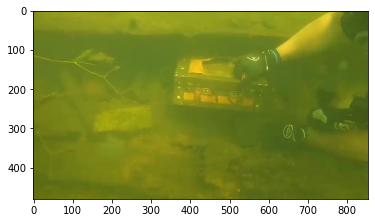

In [1]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
!pip install opencv-contrib-python
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD
from PIL import Image
from PIL import ImageFilter
import cv2
import numpy as np
#Import image
image = cv2.imread("frame.png")

#Show the image with matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


## convert image to gray scale

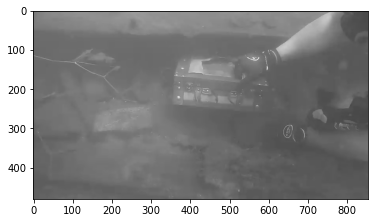

In [2]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))
plt.show()

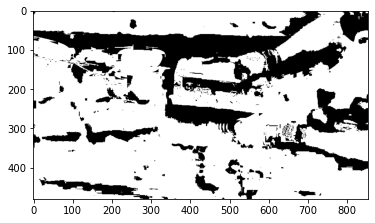

In [3]:
thresh2 = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 199, 5)
plt.imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
plt.show()

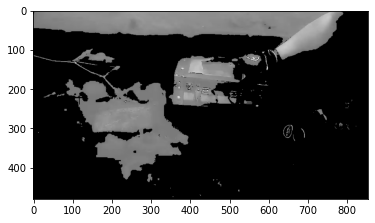

In [4]:
ok,thresh2=cv2.threshold(gray_image, 120, 255, cv2.THRESH_TOZERO)
plt.imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
plt.show()

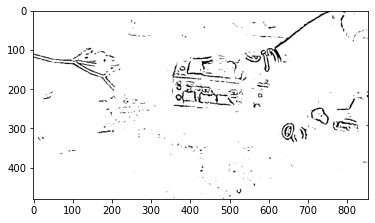

In [5]:
minValue = 70
frame=image
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #gray scale
blur = cv2.GaussianBlur(gray,(5,5),2) #gaussian blur
th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2) #adaptive inversion
ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #binary inversion
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

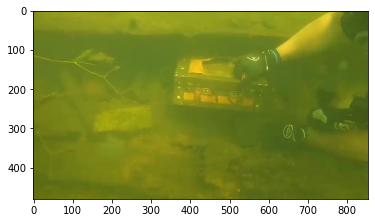

In [6]:
def process(image_name):
    image = cv2.imread(image_name)
    #Show the image with matplotlib
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
process("frame.png")

In [7]:
import cv2
def getFrames(file):
    vidcap=cv2.VideoCapture(file) #capture and read the video file
    success,image=vidcap.read()
    while success:
        cv2.imwrite("frame.png",image)
        process("frame.png") #this is the image processing function "process" where the frames are sent
        success,image=vidcap.read()
        break

In [8]:
!pip install moviepy
import moviepy.editor as mp

In [9]:
def getAudio(file):
    my_clip = mp.VideoFileClip(file)
    my_clip.audio.write_audiofile(r"finally.mp3")

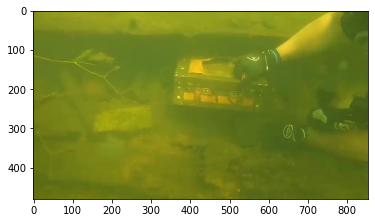

chunk:   0%|                                                             | 25/21002 [00:00<01:24, 248.18it/s, now=None]

MoviePy - Writing audio in finally.mp3


MoviePy - Done.


In [10]:
def runApplication(fileName):
    getFrames(fileName)
    getAudio(fileName) #audio is written in finally.mp3 and sent to meetingOWL project [done]
runApplication("sample.mp4")

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
!pip install keras
!pip install tensorflow
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#0 - thresholding
#1 - gray 


In [12]:
data = pd.read_csv('icml_face_data.csv')
#48 x 48

In [13]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [14]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [15]:
def driverFunction(data):
    data[' Usage'].value_counts()
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
    val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
    test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])
    train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
    train_images = train_images.astype('float32')/255
    val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
    val_images = val_images.astype('float32')/255
    test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
    test_images = test_images.astype('float32')/255
    train_labels = to_categorical(train_image_label)
    val_labels = to_categorical(val_image_label)
    test_labels = to_categorical(test_image_label)
    plot_all_emotions()
    plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')
    class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=2,
                    batch_size=64)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('test caccuracy:', test_acc)
    pred_test_labels = model.predict(test_images)
    plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 104)

In [16]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [17]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [18]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [19]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [20]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

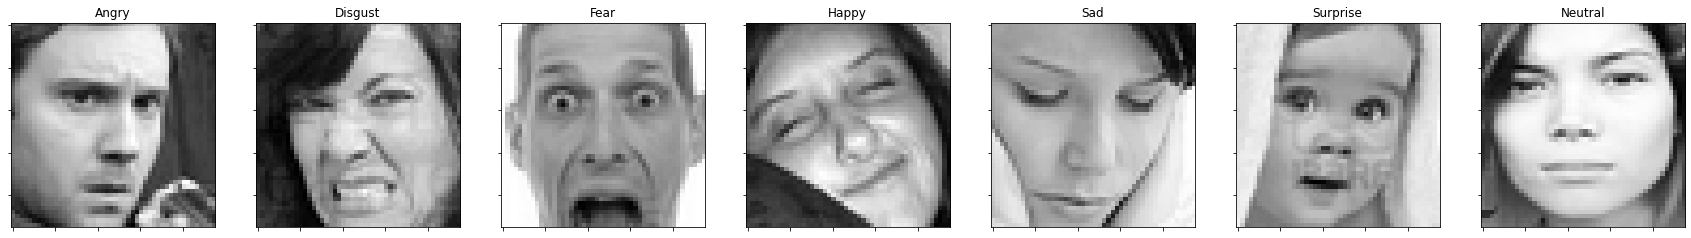

In [21]:
plot_all_emotions()

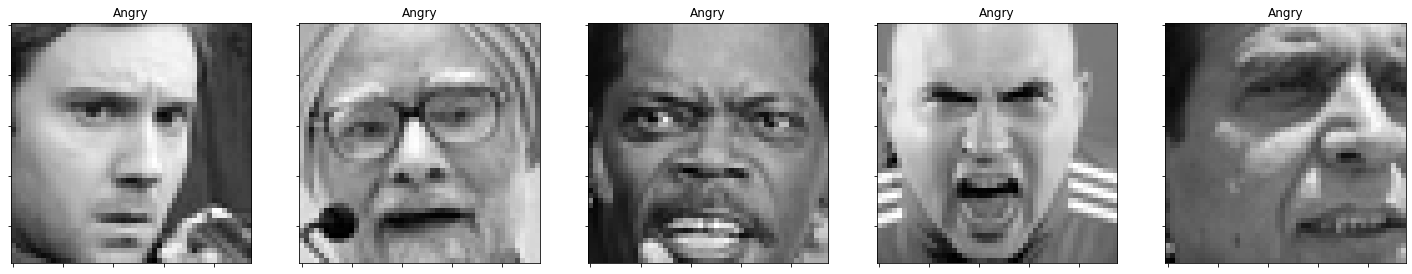

In [22]:
plot_examples(label=0)

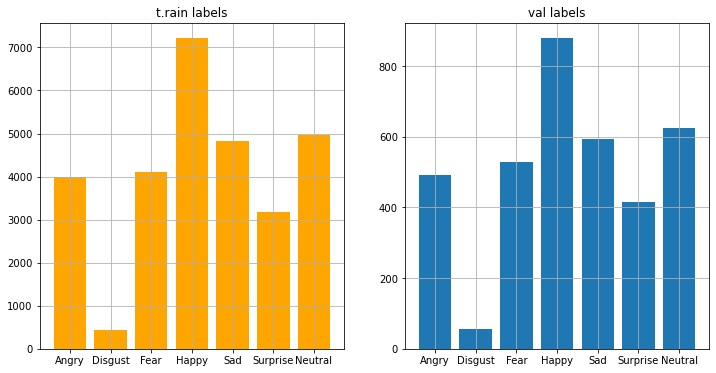

In [23]:
plot_compare_distributions(train_labels, val_labels, title1='t.rain labels', title2='val labels')

In [24]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [25]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [26]:
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [28]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=2,
                    batch_size=64)

Epoch 1/2
449/449 [==============================] - 73s 155ms/step - loss: 0.2738 - accuracy: 0.2933 - val_loss: 1.6703 - val_accuracy: 0.3739
Epoch 2/2
449/449 [==============================] - 66s 147ms/step - loss: 0.2323 - accuracy: 0.4188 - val_loss: 1.4519 - val_accuracy: 0.4430


In [29]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 23ms/step - loss: 1.4395 - accuracy: 0.4539
test caccuracy: 0.45388686656951904


In [30]:
pred_test_labels = model.predict(test_images)

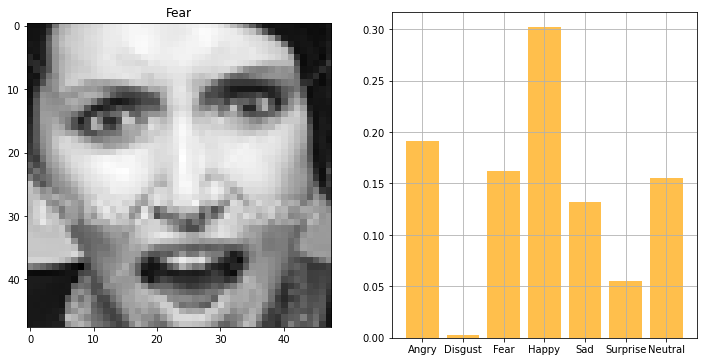

In [31]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 104)

In [32]:
def Grayscale(name1):
    img = Image.open(name1)
    imgGray = img.convert('L')
    return np.array(imgGray)

In [33]:
def Binary_Thresholding(name1,val,maxi):
    image1 = cv2.imread(name1)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(img,val,maxi, cv2.THRESH_BINARY)
    return np.array(thresh1)

In [34]:
def Truncated_Thresholding(name1,val,maxi):
    image1 = cv2.imread(name1)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh2 = cv2.threshold(img,val,maxi,cv2.THRESH_TRUNC)
    return np.array(thresh1)

In [35]:
def Thresholding_To_Zero(name1,val = 120,maxi = 255):
    image1 = cv2.imread(name1)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, thresh3 = cv2.threshold(img,val,maxi,cv2.THRESH_TOZERO)
    return np.array(thresh3)
print(Thresholding_To_Zero("frame.png"))

[[124 124 124 ...   0   0   0]
 [124 124 124 ...   0   0   0]
 [123 123 123 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [36]:
def invert(name1):
    image1 = cv2.imread(name1,0)
    image1 = cv2.bitwise_not(image1)
    return np.array(image1)

In [37]:
def sharpen(name1):
    img = Image.open(name1)
    sharpened1 = img.filter(ImageFilter.SHARPEN);
    sharpened2 = sharpened1.filter(ImageFilter.SHARPEN);
    sharpened3 = sharpened2.filter(ImageFilter.SHARPEN);
    #print(type(np.asarray(sharpened3)))
    return np.array(sharpened3)

In [38]:
def reduce(array):
    reduced=[]
    for j in array:
        row=[]
        for i in j:
            row.append(i[0])
        reduced.append(row)
    return np.array(reduced)

In [39]:
def blur(name1):
    img = cv2.imread(name1)
    img = cv2.blur(img, (3,3)) 
    return reduce(np.array(img))

In [40]:
def min(name1):
    img=Image.open(name1)
    img2=img.filter(ImageFilter.MinFilter(size=3))
    return np.array(img2)

In [41]:
def max(name1):
    img=Image.open(name1)
    img2=img.filter(ImageFilter.MaxFilter(size=3))
    return np.array(img2)

In [42]:
d={0:"Grey-scaling",1:"Thresholding",2:"Inversion",3:"Blurring"}
def GenerateCombinations(imageName, N): #give input as file name and mask, returns the new image pixel values
     #number of different operations we have [greyscaling, thresholding etc
    operationsList=[]
    for j in range(0,32):
        if(N&(1<<j)):
            operationsList.append(d[j])
    newArray=[]
    for operations in operationsList:
        enter=0
        if(operations=="Grey-scaling"):
            enter=1
            newArray=Grayscale(imageName)
        elif(operations=="Thresholding"):
            enter=1
            newArray=Binary_Thresholding(imageName, 100, 200)
        elif(operations=="Inversion"):
            enter=1
            newArray=invert(imageName)
        elif(operations == "Blurring"):
            enter=1
            newArray=blur(imageName)
        if(enter):
            new_image = Image.fromarray(newArray)
            new_image.save(imageName)
    return newArray
    
#GenerateCombinations("frame.png",4)      
# image = cv2.imread("frame.png")
# cv2.imshow('image window', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [43]:
# for mask in range((1<<4)):
#     data = pd.read_csv('icml_face_data.csv')
#     for index in range(10):
#         row=[]
#         pix=[]
#         for i in range(len(data[' pixels'].iloc[index].split(" "))):
#             row.append(int(data[' pixels'].iloc[index].split(" ")[i]))
#             if(len(row)==48):
#                 pix.append(row)
#                 row=[]
#         array = np.array(pix, dtype=np.uint8)
#         newdata=""
#         new_image = Image.fromarray(array)
#         new_image.save('dummy.png')
#         new_array=GenerateCombinations("dummy.png",mask)
#     #     image = cv2.imread("dummy.png")
#     #     new_array=Binary_Thresholding("dummy.png",100,200)
#         for i in new_array:
#             for j in i:
#                 newdata+=str(j)
#                 newdata+=" "
#         newdata=newdata[:-1]
#         data[' pixels'].iloc[index]=newdata
#     #
#     print(data.head())

In [44]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
35887


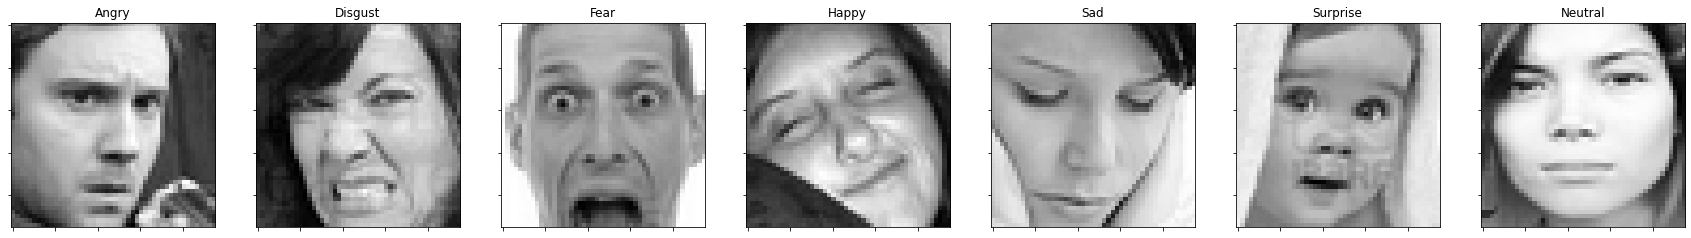

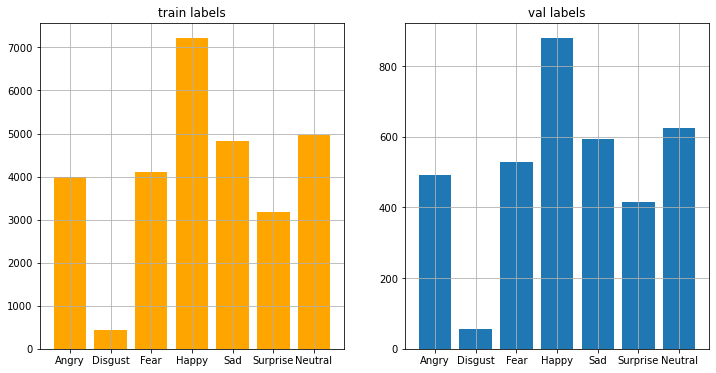

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

KeyboardInterrupt: 

In [45]:
for mask in range(1,(1<<4)):
    data = pd.read_csv('icml_face_data.csv')
    for index in range(10):
        row=[]
        pix=[]
        for i in range(len(data[' pixels'].iloc[index].split(" "))):
            row.append(int(data[' pixels'].iloc[index].split(" ")[i]))
            if(len(row)==48):
                pix.append(row)
                row=[]
        array = np.array(pix, dtype=np.uint8)
        newdata=""
        new_image = Image.fromarray(array)
        new_image.save('dummy.png')
        new_array=GenerateCombinations("dummy.png",mask)
        for i in new_array:
            for j in i:
                newdata+=str(j)
                newdata+=" "
        newdata=newdata[:-1]
        data[' pixels'].iloc[index]=newdata
    print(data.head())
    print(data.shape[0])
    driverFunction(data)
    break